In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Critical Minerals/

/content/drive/MyDrive/Critical Minerals


In [ ]:
minerals = ["Manganese", "Lithium", "Cobalt", "Nickel"]
data_directory = "." # Set this to your own directory


top_reserves_by_mineral = pd.read_csv(os.path.join(data_directory, "ReservesByMineral.csv"))
reserves_totals = top_reserves_by_mineral.groupby('Mineral', as_index=False)["Aggregate Reserves & Resources (tonnes)"].agg('sum')

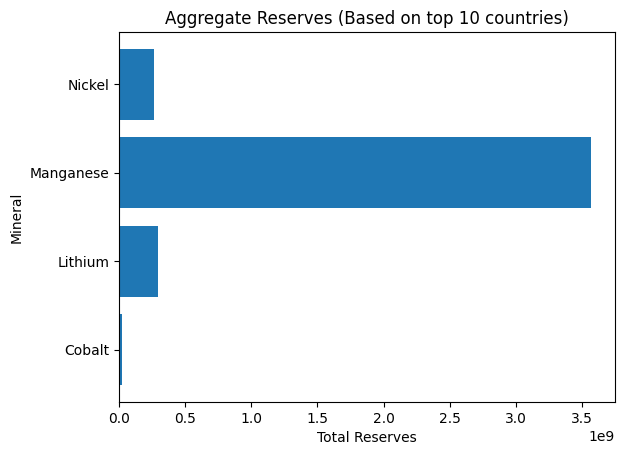

In [ ]:
plt.figure()
plt.barh(y = reserves_totals['Mineral'], width = reserves_totals["Aggregate Reserves & Resources (tonnes)"])
plt.title("Aggregate Reserves (Based on top 10 countries)")
plt.xlabel("Total Reserves")
plt.ylabel("Mineral")
plt.show()

In [ ]:
import re
combined = None

mining_path = os.path.join(data_directory, "SPGlobal_MetalsAndMiningProperties-Combined-Nov-2024.xls")
for i, mineral in enumerate(minerals):
    data = pd.read_excel(mining_path, sheet_name = mineral, header=1)
    print(f"Read {mineral}")

    data.dropna(subset="Primary Reserves and Resources", inplace = True)
    data["Reserves & Resources As Of Date"] = pd.to_datetime(data["Reserves & Resources As Of Date"])
    data["Primary Mineral"] = mineral
    data["Year"] = data["Reserves & Resources As Of Date"].dt.year


    if i == 0:
        combined = data
        continue

    combined = pd.concat([combined, data], ignore_index=True)

combined = combined.sort_values(by = "Year")
combined["Property ID"] = combined["Property ID"].astype(str)

Read Manganese
Read Lithium
Read Cobalt
Read Nickel


In [ ]:
reserves_over_time = combined \
        .groupby(["Reserves & Resources As Of Date", "Primary Mineral"], as_index = False)["Primary Reserves and Resources"] \
        .agg("sum")


fig = px.line(reserves_over_time, x="Reserves & Resources As Of Date", facet_col = "Primary Mineral",
        y="Primary Reserves and Resources", log_y = True, facet_col_wrap=2, facet_row_spacing=0.2)

fig.update_xaxes(title_text="Date")
fig.update_layout(title = "Total Reserves Over the Years", height = 600, width = 1000)
fig.update_yaxes(title_text=None)
fig.show()

In [ ]:
def get_data_by_year(df, year, cumulative = False):

    if cumulative:
        reserves_from_year = df[df["Year"] <= year].copy()
    else:
        reserves_from_year = df[df["Year"] == year].copy()

    reserves_from_year.groupby(['Property ID', "Primary Mineral"], as_index=False)["Primary Reserves and Resources"].agg('sum')
    return reserves_from_year

In [ ]:
def get_breakdown_by_mine(df, year):

    d = get_data_by_year(df, year, False)
    d = d.sort_values(by = "Property ID").set_index("Property ID")
    f = go.Figure()

    f.update_layout(
        xaxis_title="Primary Reserves and Resources (tonnes)",
        yaxis_title="Primary Mineral",
        title=f"Primary Resources and Reserves per Mine",
        legend_title="Property ID",
        barmode='stack',
        xaxis_type='log',
        xaxis_tickangle=45,
        yaxis=dict(categoryorder='total ascending')
    )


    for id,r in d.iterrows():
        f.add_trace(go.Bar(
            x=[r['Primary Reserves and Resources']],
            y=[r['Primary Mineral']],
            name = str(id),
            legendgroup=str(year),
            orientation='h',
            alignmentgroup=True,
            hovertext=[f"Property ID={id}"],
            hovertemplate="%{hovertext}<br>Primary Reserves and Resources=%{x}<br>Mineral=%{y}<extra></extra>"
        ))

    return f


In [ ]:
f = get_breakdown_by_mine(combined, 2017)
f.show()

In [ ]:
f2 = get_breakdown_by_mine(combined, 2017)
f2

In [ ]:
from copy import deepcopy

available_years = np.sort(combined["Year"].unique())[:3]
print(available_years)

sliders_dict = {
    "active": len(available_years) - 1,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Year:",
        "visible": False,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0,
    "y": 0,
    "steps": []
}


buttons_dict = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 700, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"l": 20, "t": 80},
        "showactive": False,
        "type": "buttons",
        "x": 0,
        "xanchor": "right",
        "y": 0.15,
        "yanchor": "top"
    }
]

animation = go.Figure()
M = go.Figure()
frames =  []
steps = []

for i, yr in enumerate(available_years):
    fig = get_breakdown_by_mine(combined, yr)

    M.add_traces(fig.data)
    M.update_layout(fig.layout)
    N = deepcopy(M)


    animation.add_traces(N.data)
    animation.update_layout(N.layout)

    frame = go.Frame(data=animation.data, layout = animation.layout, name=str(yr))
    frames.append(frame)
    # animation.update_layout(N.layout)

    slider_step = {"args": [[yr], {"frame": {"duration": 500, "redraw": False}}],
    "label": str(yr),
    "method": "animate"}

    sliders_dict['steps'].append(slider_step)

animation.frames = frames
animation.update_layout(updatemenus=buttons_dict,sliders=[sliders_dict])


[2016 2017 2018]
